In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load dataset
file_path = "/content/sample_data/cicdarknet2020.parquet"
df = pd.read_parquet(file_path)

# Drop non-informative columns (if needed)
df = df.dropna()  # Remove rows with missing values

# Encode categorical labels
label_encoder_label = LabelEncoder()
label_encoder_usage = LabelEncoder()

df["Label"] = label_encoder_label.fit_transform(df["Label"])      # Encode Non-Tor, NonVPN, Tor, VPN
df["Label.1"] = label_encoder_usage.fit_transform(df["Label.1"])  # Encode traffic type (Browsing, P2P, etc.)

print(df["Label"].unique(), df["Label.1"].unique()) #To check encoding


[0 1 2 3] [ 0  2  3  4  5  6  7  9  1 10  8]


In [2]:
# Method 3: Feature Importance using RandomForestClassifier
X = df.drop(columns=["Label", "Label.1"])
y = df["Label"]
# Train a RandomForest to determine feature importance, based on decision trees
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Sort features by importance
important_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print top 10 features
print("\nTop 10 Important Features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance:.4f}")
sum = 0
for feature, importance in important_features:
    sum += importance
print("sum of all importances: ", sum)

# Drop low-importance features (threshold = 0.005)
low_importance_features = [f for f, imp in important_features if imp < 0.005]
print("Low Importance features are:", low_importance_features)
df_processed = df.drop(columns=low_importance_features)

print(f"\nDropped {len(low_importance_features)} low-importance features.")
print("Remaining features:", df_processed.columns)
#print(df_processed.describe()) #Use this line to show the dataset after feature selection to sir



Top 10 Important Features:
FWD Init Win Bytes: 0.0840
Idle Max: 0.0752
Idle Mean: 0.0610
Idle Min: 0.0580
Fwd Seg Size Min: 0.0476
Bwd Init Win Bytes: 0.0392
Flow IAT Max: 0.0254
Bwd Packets/s: 0.0253
Bwd Packet Length Min: 0.0250
Flow IAT Min: 0.0242
sum of all importances:  1.0
Low Importance features are: ['Idle Std', 'Subflow Fwd Packets', 'Bwd IAT Total', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd Packet Length Std', 'Fwd IAT Std', 'Bwd IAT Min', 'Fwd Packet Length Std', 'Bwd Bulk Rate Avg', 'Down/Up Ratio', 'RST Flag Count', 'PSH Flag Count', 'Bwd IAT Std', 'SYN Flag Count', 'Bwd Packet/Bulk Avg', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Subflow Bwd Packets', 'Active Mean', 'Active Std', 'Active Max', 'Active Min']

Dropped 32 low-importance features.
Remaining features: Index(['Protocol', 'Flow Duration', 'Total Fwd P

In [3]:
# Normalize numerical features
# Select numerical features (excluding labels)
features = df.drop(columns=["Label", "Label.1"])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# Rn the features_scaled is a numpy array, so
# Convert back to DataFrame
df_processed = pd.DataFrame(features_scaled, columns=features.columns)
# Adding back the removed data
df_processed["Label"] = df["Label"]
df_processed["Label.1"] = df["Label.1"]
#print(df_processed.describe()) #Use this line to show the dataset after feature selection to sir


In [4]:
# Split dataset (80% train, 20% test)
X = df_processed.drop(columns=["Label", "Label.1"])
y = df_processed["Label"]  # Primary classification (Non-Tor, NonVPN, Tor, VPN)
y_usage = df_processed["Label.1"]  # Secondary classification (Browsing, P2P, etc.)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, _, y_usage_train, y_usage_test = train_test_split(X, y_usage, test_size=0.2, random_state=42, stratify=y_usage)

# Reshaping input to (samples, height, width, channels)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Print dataset information
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Unique traffic labels:", label_encoder_label.classes_)  # Display class names for "Label"
print("Unique usage types:", label_encoder_usage.classes_)  # Display class names for "Label.1"

Training set shape: (82496, 77)
Testing set shape: (20625, 77)
Unique traffic labels: ['Non-Tor' 'NonVPN' 'Tor' 'VPN']
Unique usage types: ['AUDIO-STREAMING' 'Audio-Streaming' 'Browsing' 'Chat' 'Email'
 'File-Transfer' 'File-transfer' 'P2P' 'VOIP' 'Video-Streaming'
 'Video-streaming']


In [5]:
#Checking if Preprocessing was done right:
print(df.isnull().sum())  # Should return 0 for all columns

Protocol                      0
Flow Duration                 0
Total Fwd Packet              0
Total Bwd packets             0
Total Length of Fwd Packet    0
                             ..
Idle Std                      0
Idle Max                      0
Idle Min                      0
Label                         0
Label.1                       0
Length: 79, dtype: int64


In [6]:
print(f"Duplicate Entries: {df.duplicated().sum()}")  # Should return 0

Duplicate Entries: 0


In [7]:
print(f"X_train Shape: {X_train.shape}, X_test Shape: {X_test.shape}")

X_train Shape: (82496, 77), X_test Shape: (20625, 77)


In [8]:
import numpy as np
print(np.unique(y_train))  # Should be [0, 1]


[0 1 2 3]


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Reshape the data (if not already reshaped)
X_train = X_train.reshape(X_train.shape[0], 77, 1)  # (samples, features, 1)
X_test = X_test.reshape(X_test.shape[0], 77, 1)

# Define the 1D CNN model
model = Sequential()

# Increase Conv1D filter size
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(77, 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Helps prevent overfitting

model.add(Dense(4, activation='softmax'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 73, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 36, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 32, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 567,044 (2.16 MB)

 Trainable params: 567,044 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Define TensorBoard log directory
logdir = '/content/sample_data/traffic_classification_logs'

# Set up TensorBoard callback for logging training metrics
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=30,  # Number of times the model will go through the dataset
    validation_data=(X_test, y_test),  # Validation data to check performance after each epoch
    callbacks=[tensorboard_callback],  # Enables logging for TensorBoard visualization
    batch_size=64  # Adjust batch size for memory efficiency
)


Epoch 1/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.8431 - loss: 0.4251 - val_accuracy: 0.9062 - val_loss: 0.2580
Epoch 2/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9154 - loss: 0.2363 - val_accuracy: 0.9247 - val_loss: 0.1995
Epoch 3/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.9257 - loss: 0.1997 - val_accuracy: 0.9324 - val_loss: 0.1826
Epoch 4/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.9328 - loss: 0.1797 - val_accuracy: 0.9380 - val_loss: 0.1675
Epoch 5/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.9339 - loss: 0.1734 - val_accuracy: 0.9393 - val_loss: 0.1628
Epoch 6/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9350 - loss: 0.1699 - val_accuracy: 0.9370 - val_loss: 0.1660
Epoch 7/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9392 - loss: 0.1605 - val_accuracy: 0.9390 - val_loss: 0.1664
Epoch 8/30
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.9392 -

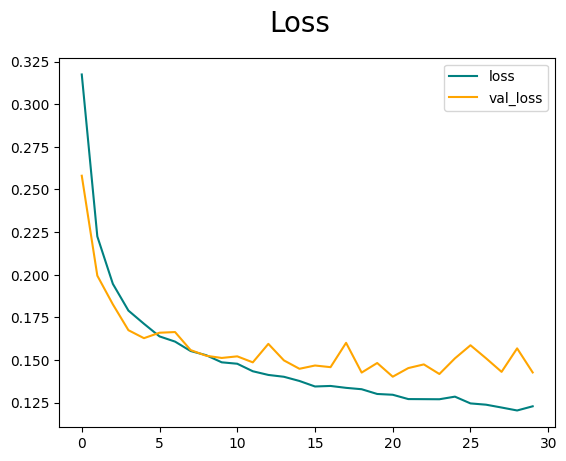

In [11]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc="upper right")
plt.show()

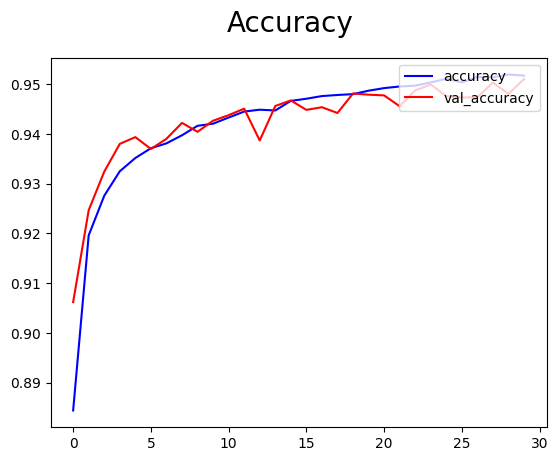

In [12]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc="upper right")
plt.show()

645/645 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
Precision: 0.9936214685440063
Recall: 0.9959551095962524
Accuracy: 1.0


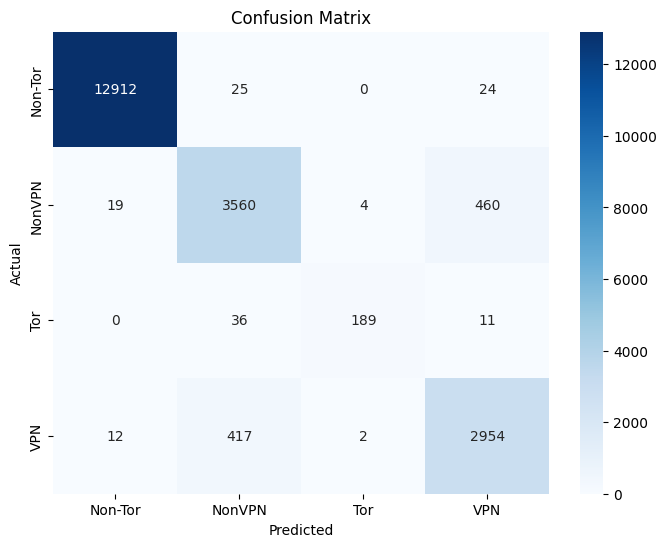

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     12961
      NonVPN       0.88      0.88      0.88      4043
         Tor       0.97      0.80      0.88       236
         VPN       0.86      0.87      0.86      3385

    accuracy                           0.95     20625
   macro avg       0.93      0.89      0.90     20625
weighted avg       0.95      0.95      0.95     20625



In [14]:
#Evaluation
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

# Creating instances of the metrics
pre = Precision()
re = Recall() # measures how many actual positives were correctly predicted
acc = CategoricalAccuracy()

# Evaluating the model on the test dataset
yhat = model.predict(X_test)

# Convert predictions to class indices
yhat = tf.argmax(yhat, axis=1) # gives probabilities for each class

# Update metric states
pre.update_state(y_test, yhat)
re.update_state(y_test, yhat)
acc.update_state(y_test, yhat)

# Printing results
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

# Confusion Matrix
# A confusion matrix is a table used to evaluate the performance of a classification model. It compares the actual labels (ground truth) with the predicted labels from the model.
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, yhat)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_label.classes_, yticklabels=label_encoder_label.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, yhat, target_names=label_encoder_label.classes_))

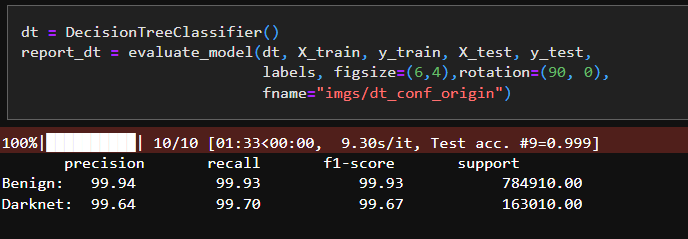

In [37]:
#Testing on single sample
# Select a random test sample
idx = np.random.randint(0, X_test.shape[0])  # Pick a random test sample
sample = X_test[idx].reshape(1, 77, 1)  # Reshape to CNN input format

# Predict class
yhat = model.predict(sample)
predicted_class = np.argmax(yhat)
df = pd.DataFrame({"Confidence Scores": yhat[0]})

# Display with 20 decimal places
pd.options.display.float_format = '{:.20f}'.format

# Print the result
print(f"\nPredicted Traffic Type: {label_encoder_label.classes_[predicted_class]}")
print(f"Confidence Scores: {df}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Predicted Traffic Type: Non-Tor
Confidence Scores:        Confidence Scores
0 0.99999976158142089844
1 0.00000018345096464145
2 0.00000000000000000000
3 0.00000000000516021947
